```{eval-rst}
.. include:: ../sinebow.rst

```
{header-2}`Multiple channels`
=============================
Omnipose inherits the capability of Cellpose to segment based on multi-channel images. We will use this as an opportunity to show how we can run several models at once on the same image(s), in this case comparing Omnipose to Cellpose trained on the cyto2 dataset. 

In [ ]:
%load_ext autoreload
%autoreload 2

# First, import dependencies.
import numpy as np
import time, os, sys
from cellpose_omni import models, core, utils


# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if 
# you are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# for plotting 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300


2022-07-25 23:35:17,636 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1


## Load file
This is one of the images from the cyto2 test dataset. Note that it is a good idea to always work with lists, even when the list of images is 1 long. It allows you to reuse your code easily when you do have a larger set of images to process. 

In [ ]:
from urllib.parse import urlparse
import skimage.io


urls = ['http://www.cellpose.org/static/images/img02.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

Downloading: "http://www.cellpose.org/static/images/img02.png" to img02.png
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131k/131k [00:00<00:00, 582kB/s]


In [ ]:
imgs = [skimage.io.imread(f) for f in files]
imgs = [np.stack((im[...,-1],im[...,1])) for im in imgs] # put cytosol in 1st channel, nucleus in 2nd
nimg = len(imgs)
imgs[0].shape

(2, 349, 467)

Read in the images from the file list. It's a good idea to display the images before proceeding. 

(2, 349, 467)
1


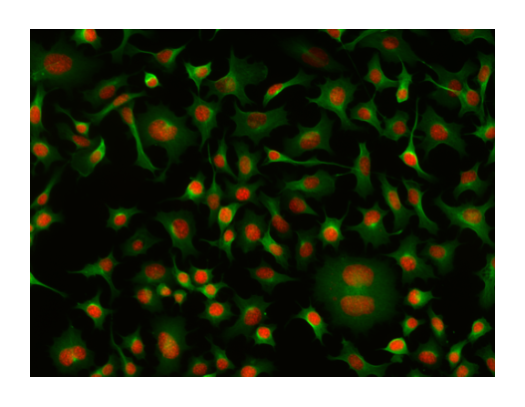

In [ ]:
from cellpose_omni import io, transforms 

# print some infor about the images 
for i in imgs:
    print(i.shape)
nimg = len(imgs)
print(nimg)

plt.figure(figsize=[2]*2) # initialize figure
for k in range(len(imgs)):
    # img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    imgs[k] = transforms.normalize99(imgs[k],omni=True)
    plt.subplot(1,len(files),k+1)
    rgb = np.stack((imgs[k][0],imgs[k][1],np.zeros_like(imgs[k][0])),axis=-1)
    plt.imshow(rgb) 
    plt.axis('off')

## Initialize models
most recent model traied via 
python -m cellpose --train --use_gpu --dir /home/kcutler/DataDrive/cyto2/train --mask_filter _masks --n_epochs 4000 --pretrained_model None  --learning_rate 0.1 --diameter 36 --save_every 50 --save_each --omni --verbose --chan 1 --chan2 2 --RAdam --batch_size 16 --img_filter _img


In [ ]:
# model_name = ['cyto2','cyto2_omni']
# L = len(model_name)
# model = [models.CellposeModel(gpu=use_GPU, model_type=model_name[i]) for i in range(L)]
model_name = ['cyto2','cyto2_omni']
L = len(model_name)

model = [models.CellposeModel(gpu=use_GPU, model_type=model_name[0]), 
         models.CellposeModel(gpu=use_GPU, model_type=model_name[1])]


2022-07-25 23:35:24,711 [INFO] >>cyto2<< model set to be used
2022-07-25 23:35:24,712 [INFO] ** TORCH CUDA version installed and working. **
2022-07-25 23:35:24,712 [INFO] >>>> using GPU
2022-07-25 23:35:24,821 [INFO] >>cyto2_omni<< model set to be used
2022-07-25 23:35:24,821 [INFO] ** TORCH CUDA version installed and working. **
2022-07-25 23:35:24,821 [INFO] >>>> using GPU


## Run segmentation 
The channels input can be very confusing. In the Cellpose documentation, it is stated that the list `[chan,chan2]` should represent the main channel to segment (`chan`) and the optional nuclear channel (`chan2`). But to train via CLI, `chan` is the "channel to segment" and `chan2` is the nuclear channel, and the Cellpose team states the CLI command used to train their model used `--chan 2 --chan2 1`. Because 0 is grayscale and 1,2,3 are R,G,B (1-based indexing, unlike the Python convention) this means that the given training command actually trains with GREEN cytosol and RED nuclei. This might imply that the cyto2_omni model actually is trained 'incorrectly'. 

On top of this, the downloaded image has blue nuclei and green cytosol, whereas the cyto2 dataset shows cytosol as channel 0 and nuclei as channel 1. So in fact, I should have trained the cyto2_omni model with `--chan 1 --chan2 2`. (Have not yet done this with most recent models...) Keep this in mind as you train your own models. For now, the following shows what channel arguments you need for the provided cyto2 models:

In [ ]:
chans = [[2,1],[1,2]] # green cytoplasm [2] and red nucleus [1], see above 
n = range(nimg) 

# define parameters
mask_threshold = [-1,-1,-2] #new model might need a bit lower 
verbose = 0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale= None # give this a number if you need to upscale or downscale your images
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = False #whether or not to run dynamics on rescaled grid or original grid 

N = L+1 # three options: pure cellpose, mixed, omnipose, new omnipose
omni = [0,1,1]
ind = [0,0,1]
masks, flows, styles = [[]]*N, [[]]*N, [[]]*N

diameter = 33
for i in range(N):
    masks[i], flows[i], styles[i] = model[ind[i]].eval([imgs[i] for i in n],channels=chans[ind[i]],diameter=diameter,
                                                       mask_threshold=mask_threshold[i],
                                                       transparency=transparency,flow_threshold=flow_threshold,
                                                       omni=omni[i], #toggle omni
                                                       resample=resample,verbose=verbose, 
                                                       cluster=omni[i],
                                                       interp=True, tile=False)

## Plot the results

model is: cyto2 , omni is: 0


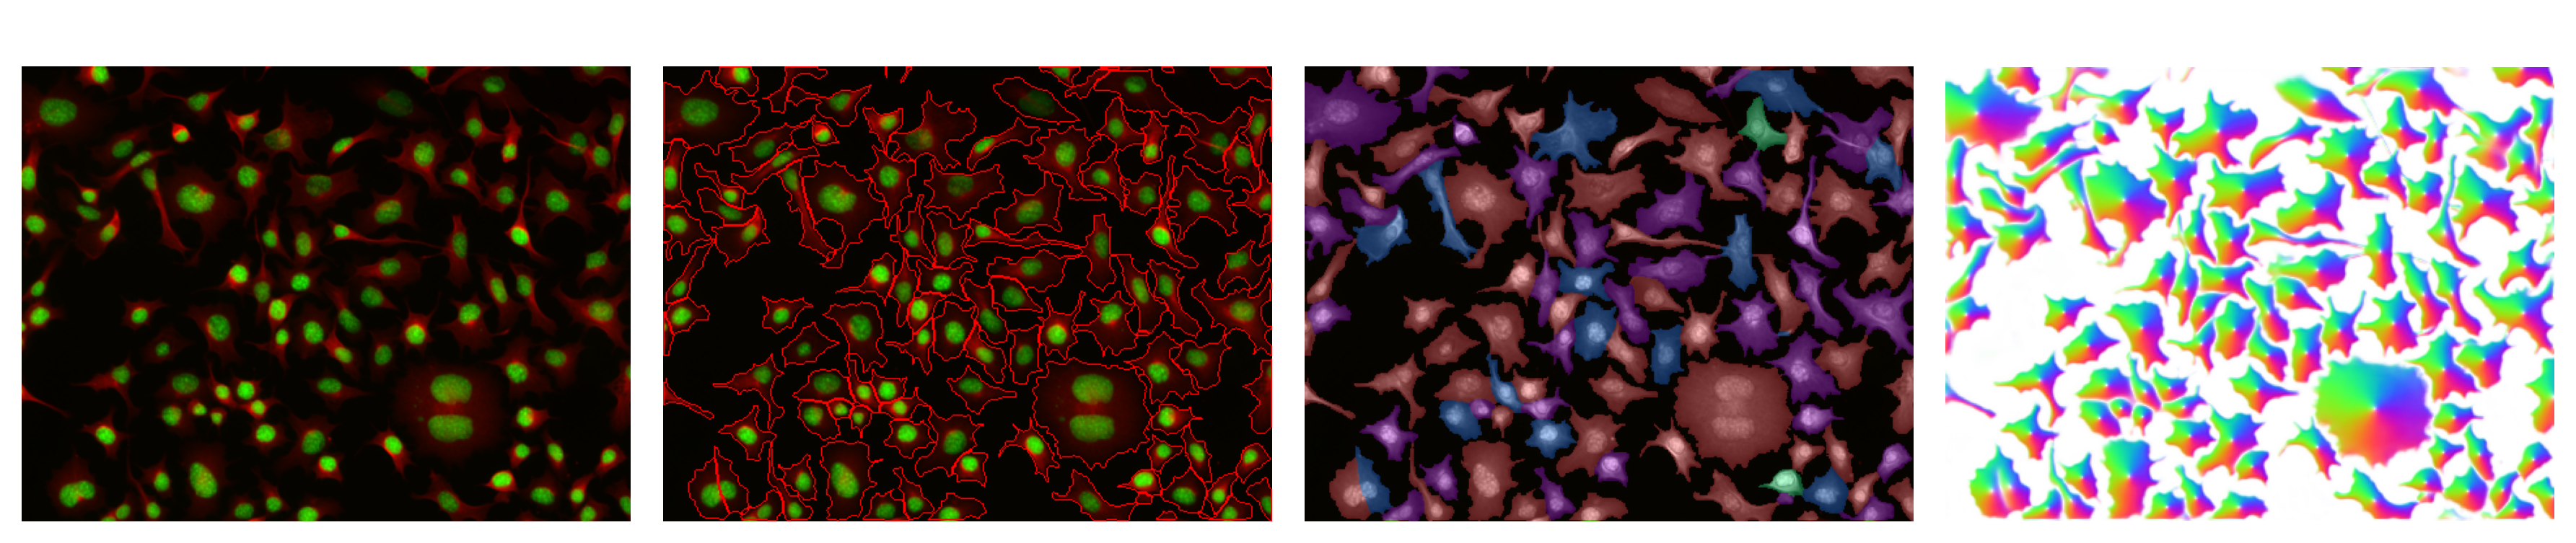

model is: cyto2 , omni is: 0


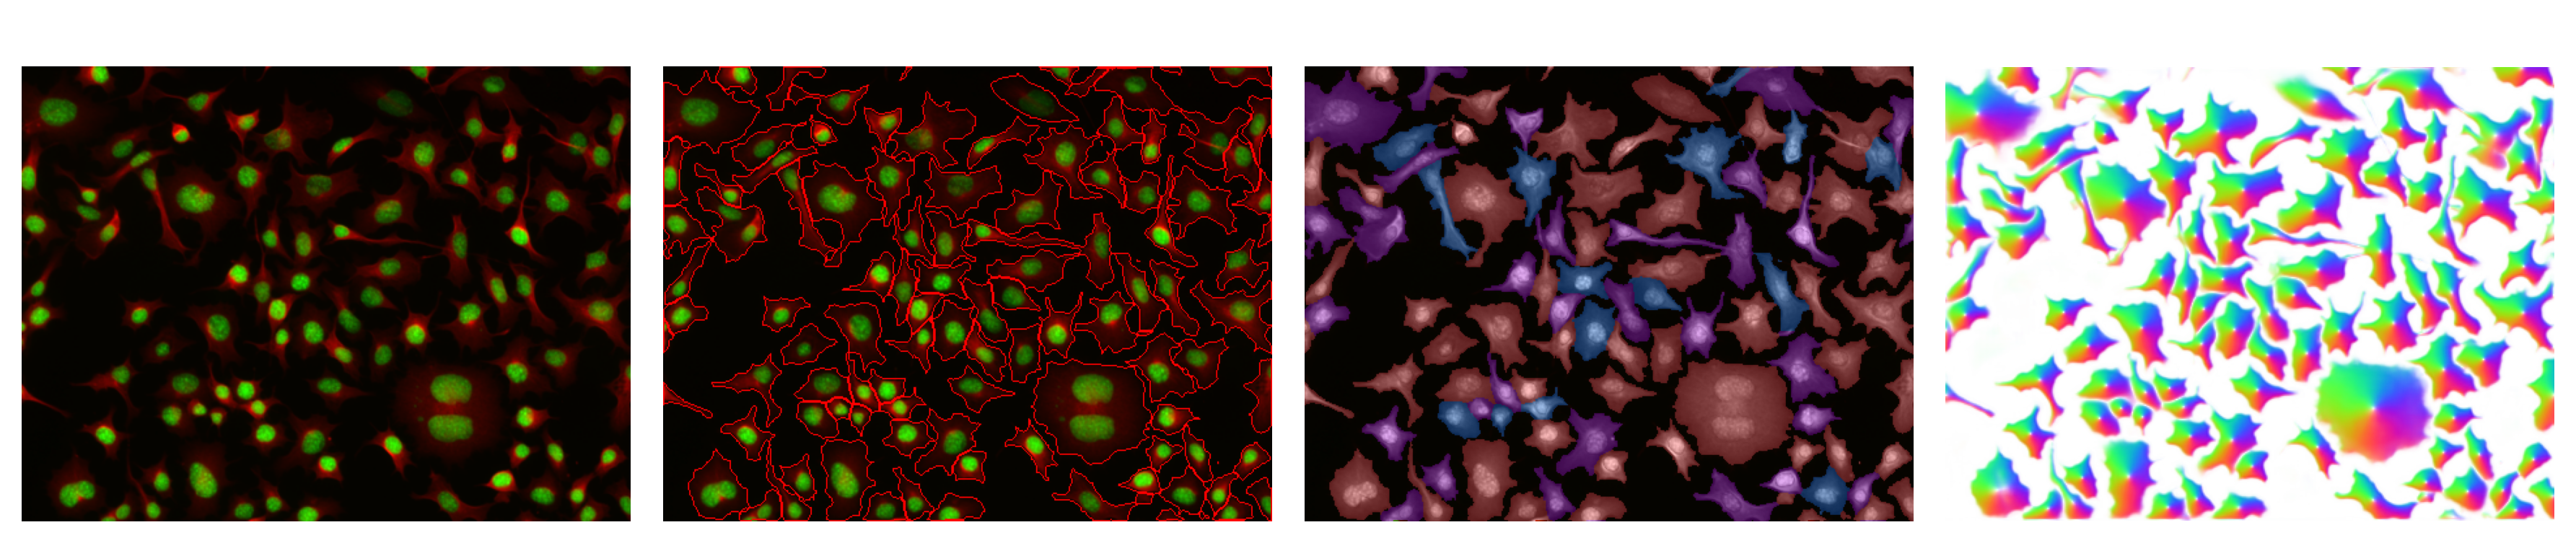

model is: cyto2_omni , omni is: 1


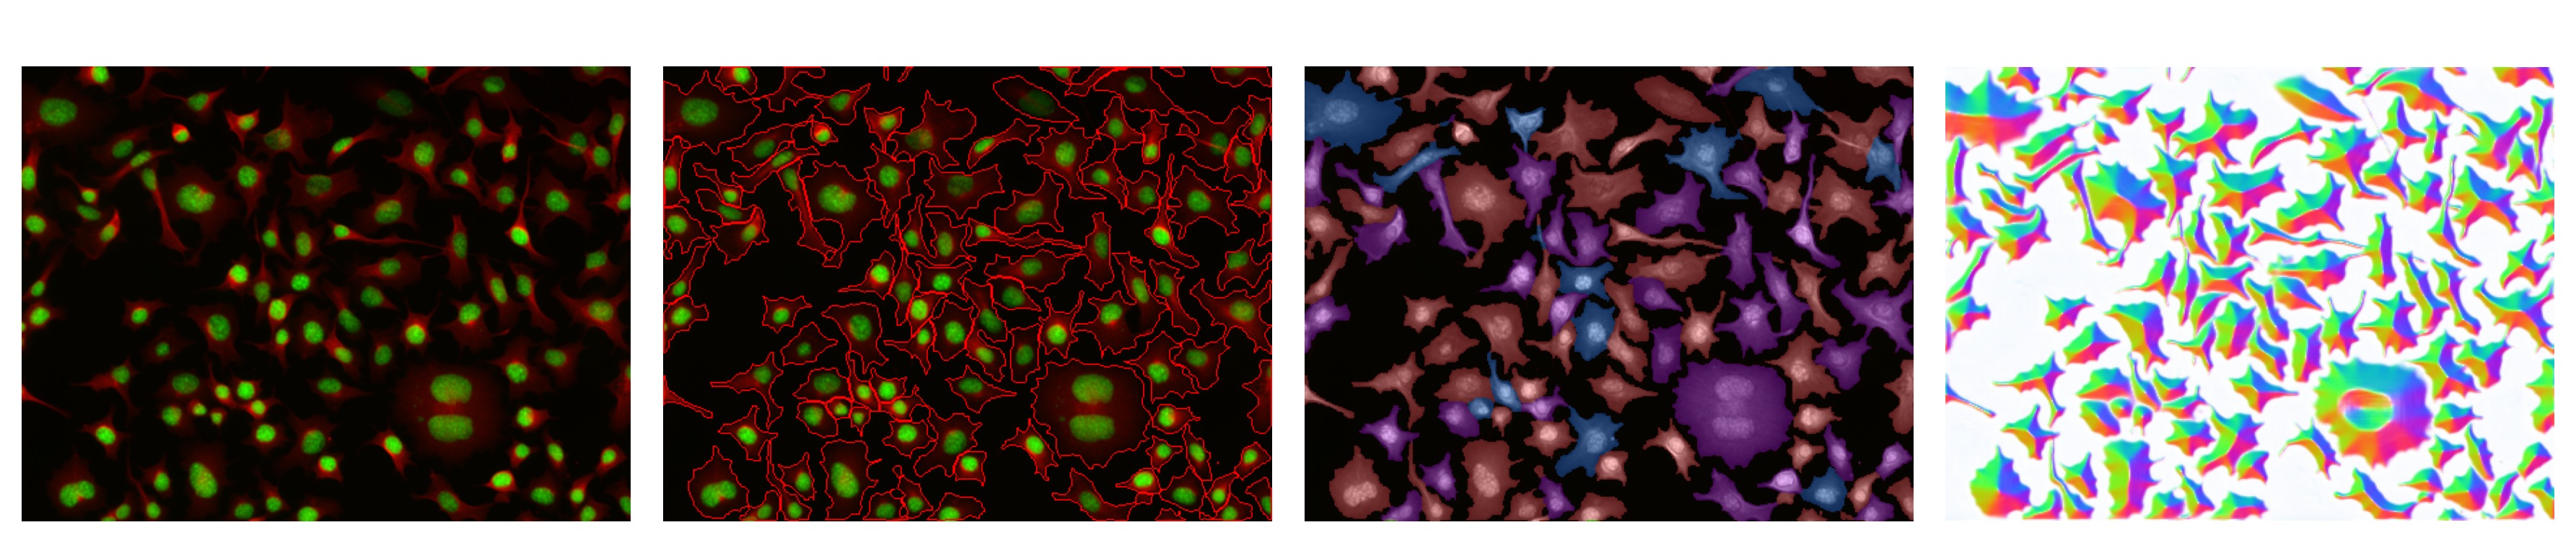

In [ ]:
from cellpose_omni import plot
import omnipose

for idx,i in enumerate(n):
    
    for k,ki in enumerate(ind):
        
        print('model is:',model_name[ki],', omni is:',omni[ki])
        maski = masks[k][idx]
        flowi = flows[k][idx][0]
        fig = plt.figure(figsize=(12,5))
        # im = transforms.move_min_dim(imgs[i])
        # print(im.shape)
        plot.show_segmentation(fig, imgs[i], maski, flowi, channels=chans[i], omni=True, bg_color=0)
        plt.tight_layout()
        plt.show()

Some comments on the above: Omnipose pre-processes the images slightly differently (see `normalize99`) and therefore the flow is a bit different even with the same model and input image compared to stock cyto2. The `cluster` option helps a lot to get accurate masks with Omnipose in thin regions, but can result in under-segmentation between cells with poorly-defined flow fields. This can be a weakness of Omnipose relative to Cellpose, but as seen in the paper, Omnipose does slightly better than Cellpose of the cyto2 dataset on average, indicating that it does better in some areas and worse in others. 